# Project: App-Review Miner
Team members: Shanshan Li, Yingyezhe Jin, Tianshu Chu, Xiao Huang

## I. Introduction and Problem Statement
The rapid growth of the smartphone market attracts increasing groups of developers to build mobile applications (Apps)  that are reforming our daily life. Given the keen competitions among apps and violently evolving of user preference, developers could no longer act blindly. They often prefer to put apps online first and then iteratively improve apps based on feedback. The timely informative interactions could not only help develops debug more efficiently, but also often reflect user preference. Developers could leverage them as a key guidance to improve the user experience. Unlike other commercial software that relies more on traditional channels such as crashing reports, emails, bug repositories and online forums, mobile apps have a special rich interactive information source, i.e., reviews and ratings in app marketplaces such as Google Play and App Store.

** Challenges. **
Given the extensive reviews available, however, it is not a trivial task to mine the informative user feedback from them, i.e., app-review miner. There are two major challenges. First, there is no clear definition of informative reviews. For different types of apps, informative feedback could be diverse. Even for app developers, they may all have different understandings of informative. Second, the number of reviews could be in large-scale, especially for the popular apps. It is impossible to tackle these reviews manually. Moreover, the informative reviews only occupy a small proportion of the total. Motivated by the work of [1], in this project, we implement an app-review miner to extract informative reviews for developers from app marketplace. 

** Research Problem Definition. **
We formally define the app-review miner problem as follows. A review is defined as “informative” if it contains information that app developers are looking to identify and is potentially useful for improving the quality or user experience. Given a set of reviews and corresponding ratings of an app, with only a small proportion of reviews have labels indicating informative or not, we aim to find all the informative reviews, and rank them according to the importance to developers.

## II. Related Work
The literature has covered two main categories of related work, i.e., app market analysis and user review analysis. First, it has been pointed out that mobile app marketplaces are different than traditional ones from various aspects such as technical, customer, business, and APIs [5,6]. Few efforts have been devoted to utilizing user reviews in Marketplaces. Carreno and Winbladh explored a topic learning framework for requirement changes based on sentiment analysis. Fu et al. [7] focused on analyzing users’ dissatisfaction by modeling the relationship of the negative reviews and the development of an app. Second, many efforts have been devoted to investigating user reviews of traditional marketplaces such as movies and commodity goods based on sentiment analysis [8]. The key idea is to learn the emotional features in reviews and classifies them into “positive” and “negative” classes. However, existing methods cannot be directly applied to our problem. We also need to rank the reviews according to the importance to save developers’ efforts. Another well-studied related topic is spam detection [9], whose methods can be utilized in our project to filter out spammy reviews.

## III. Proposed App-Review Miner Framework

To address the app-review miner problem, we implement an automated review analysis framework - App-Review Miner. It contains four major components, i.e., ** 1. NLP based preprocessing -> 2. Naive Bayes based filtering -> 3. LDA topic modeling based grouping -> 4. Ranking algorithms for importance**. First, we use natural language processing (NLP) techniques such as tokenization, stemming, and casefolding to preprocess the raw user review data into a well-structured format. Second, to filter out non-informative reviews automatically, we train a classifier with Expectation Maximization for Naive Bayes (EMNB) [2]. Third, we group the remaining “informative” reviews through Latent Dirichlet Allocation (LDA) [3] topic modeling algorithm, in such a way that reviews in the same group are more semantically similar to each other than those in other groups. Fourth, we learn different non-trivial features for groups and reviews in each group, and prioritize them according to their level of importance. In the end, we also visualize the ranking results of all valuable information and present an intuitive summary report to app developers.

**Datasets:** The original ones from the work of [1]. https://sites.google.com/site/appsuserreviews/ They are the user reviews of four apps from Google Play, i.e., SwiftKey Keyboard, Facebook, Temple Run 2, and Tap Fish, with time period from Oct, 2012 to Feb, 2013.

**Python Packages:** cs670, sklearn, nltk.

### 1. NLP based preprocessing
We preprocess the raw data, and return all the reviews in a predefined dictionary format.

     Inputs: datasetName    is name of four apps to select raw data, i.e., facebook, templerun2, swiftkey, tapfish
             rmStopWords    is the indicator of removing stop words or not
             rmRareWords    is the indicator of removing rarely occured words or not
             skParse        is the indicator of directly reading the data that has been filtered out or not
             
    Outputs: trainSet       is a list of training reviews, dictionary of {label, reviews} for review data
             testSet        is a list of testing reviews, dictionary of {label, reviews} for review data
             unlabelSet     is a list of unlabeld reviews, dictionary of {label, reviews} for review data
             vocabulary     is a vocabulary list in a dictionary form {word, index}, it only contains words from 
                               training set with length V

In [36]:
%run ./AR_util.py
%run ./AR_reviewInstance.py

# Inputs:
datasetName = "swiftkey" # four apps: facebook, templerun2, swiftkey, tapfish
rmStopWords = True # Removing stop words lead to information loss and bad f-score
rmRareWords = False
skParse = False # set skParse True to directly read of the data that has been filtered out

# Outputs:
if(skParse == False):
    trainSet, testSet, unlabelSet, vocabulary = AR_parse(datasetName, rmStopWords, rmRareWords)
print trainSet[1].printSelf()

Vocabulary size for swiftkey : 3074
Training set Size: 1000
Testing set Size: 2000
Unlabeling set Size: 3282
Review id: 1 Rating: 4 Content: 2 languag select mostli make predict one Ntokens: 7 TS:  Group:  Prob: 0 label: 1
Raw text: when it has 2 languages selected it mostly makes predictions in one
None
None
None
None


### 2. Naive Bayes based filtering
We implement two algorithms to classify the reviews into {informative, non-informative} classes. The frist one is Expectation Maximization for Naive Bayes (EMNB) [2], and the second one is Support vector machine (SVM). We use F1 score to measure the performance of these two types of classifiers.

     Inputs: trainSet       is a list of preprocessed training reviews
             testSet        is a list of preprocessed testing reviews
             unlabelSet     is a list of preprocessed unlabeld reviews
             vocabulary     is the vocabulary list in a dictionary form {word, index}
             useSVM         is the indicator of using SVM or not
             
    Outputs: informRev      is a list of informative reviews
             informMat      is a X*V np sparse matrix, where X is the number of informative reviews, V is the length
                               of vocabulary

In [37]:
%run ./AR_classifier.py

useSVM = True # SVM is way better than EMNB in the testing, but it may not filter out the information effectively
if(skParse == False):
    if(useSVM == False):
        informRev, informMat = AR_emnb(trainSet, testSet, unlabelSet, vocabulary, datasetName)
    else:
        informRev, informMat = AR_svm(trainSet, testSet, unlabelSet, vocabulary, datasetName)
    # write the result back to the file (optional)
    AR_writeReviews(informRev, datasetName)
    
else:
    # directly read from the file
    informRev, informMat, vocabulary = AR_loadReviews(datasetName)

print("Number of informative reviews: " + str(len(informRev)))
print informRev[1].printSelf()

Average F-Score for the test data: 0.791471170889
Number of informative reviews: 757
Review id: 3003 Rating: 1 Content: crash chrome everi 5 minut Ntokens: 5 TS:  Group:  Prob: 1.0 label: 1
Raw text: crashes chrome every 5 minutes
None
None
None
None


### 3. LDA topic clustering

We use LDA to group all the informative reviews based on the topic. We also return the top seven words in each topic.

     Inputs: informMat       is the X*V np sparse matrix, where X is the number of informative reviews
             vocabulary      is the vocabulary list in a dictionary form {word, index}
             n_topics        is the number of topics
             
    Outputs: doc_topic       is a X*n_topics np matrix, indicating the probability of beloging to each topic
             vocab           is the vocabulary in the list form

In [50]:
%run ./AR_lda.py

n_topics = 20 # the number of topics
doc_topic, vocab, top_words_list = AR_lda(informMat, vocabulary, n_topics)

INFO:lda:n_documents: 757
INFO:lda:vocab_size: 3074
INFO:lda:n_words: 6477
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -77356
INFO:lda:<500> log likelihood: -46772
INFO:lda:<999> log likelihood: -46690


Topic 0: keyboard need one app button close also
Topic 1: 5 star would swype miss give charact
Topic 2: work predict text messag correct sometim auto
Topic 3: option pleas add person great make dictionari
Topic 4: app work get well make dictionari could
Topic 5: keyboard default time everi set back swiftkey
Topic 6: languag download pack english get error cannot
Topic 7: would keyboard like theme could one wish
Topic 8: email use thing mani featur find address
Topic 9: key press option long symbol number also
Topic 10: use predict word even much accur text
Topic 11: 2 key 1 4 updat samsung note
Topic 12: good still search freez alway de googl
Topic 13: theme like would nice love though pop
Topic 14: word type swipe select delet letter sentenc
Topic 15: type phone lag seem bit keyboard howev
Topic 16: theme need wish keyboard add new realli
Topic 17: support chines pleas languag input japanes soon
Topic 18: updat get sinc problem jelli bean bug
Topic 19: space bar punctuat predict inser

###  4. Ranking algorithms for importance
In this component, we perform two types of ranking, i.e., ranking all the groups and ranking all the reviews in each group.

####  4.1 ranking all the groups based on the importance of topics
We treat each topic as one group, and each row of "doc_topic" indicates the probabilities of a review belongs to corresponding topics. The importance of a group is evaluated according to two types of features. The first one is the sum of all the informative reviews' probabilities of belonging to this group. The key idea is that the more reviews belongs to a group, the more important a group is. The mathematically experssion is defined in Eq.(1) in the work of [1]. The second feature is the inverse of the average rating of this group. The key idea is lower ratings indicating stronger dissatisfaction from the users. The mathematically experssion is defined in Eq.(3) in the work of [1].

     Inputs: doc_topic       is a X*n_topics np matrix, indicating the probability of beloging to each topic
             informRev       is a list of informative reviews   
             wg              are the weights of the probability feature and rating feature
             
    Outputs: group_scores    is a 1*20 vector, indicating importance of each group in order    
             sorted_indices  is a 1*20 vector, indicating the group indices in order of importance

In [65]:
%run ./AR_ranker.py

wg = [0.85, 0.15]
group_scores, sorted_group_indices = group_rank(doc_topic, wg, informRev)
print('Group scores:\n' + str(group_scores) + '\n')
print('Group in order of importance:\n' + str(sorted_group_indices))

Group scores:
[40.680858917604773, 39.079602258553138, 39.054935531974493, 37.336194862451038, 36.350043586649377, 35.372279785731521, 34.779076768720515, 33.248923697363246, 32.918674927883238, 32.688303857675699, 31.65391356449582, 30.947957790646615, 30.925528465205318, 30.788774550458484, 29.718217188955791, 29.43849528052079, 28.600899728663506, 27.236081473649847, 23.792620388196099, 19.687325313845218]

Group in order:
[7, 16, 5, 3, 17, 14, 0, 18, 19, 2, 15, 6, 10, 9, 13, 4, 11, 8, 1, 12]


#### 4.2 ranking all the reviews in each group
We implement two algorithms to ranking the reviews in a group, i.e., topic modeling based and text rank [11] based. 

#### 4.2.1 text rank based review ranking
The key idea is to construct a graph by treating each review as a node and connecting nodes with common words, and then perform page rank on the graph to rank the reviews.

     Inputs: doc_topic       is a X*n_topics np matrix, indicating the probability of beloging to each topic
             informRev       is a list of informative reviews   
             
    Outputs: rankedInstance  is the ranking in a dict = {topic, list of ranked reviews with the score}

In [54]:
%run ./AR_textrank.py

AR_tfIdf(informRev)
rankedInstance = AR_textrank(doc_topic, informRev)

In construct the graph of reviews ---- Nodes: 49 Edges: 24
In construct the graph of reviews ---- Nodes: 29 Edges: 34
In construct the graph of reviews ---- Nodes: 48 Edges: 64
In construct the graph of reviews ---- Nodes: 59 Edges: 82
In construct the graph of reviews ---- Nodes: 33 Edges: 2
In construct the graph of reviews ---- Nodes: 49 Edges: 90
In construct the graph of reviews ---- Nodes: 39 Edges: 76
In construct the graph of reviews ---- Nodes: 56 Edges: 50
In construct the graph of reviews ---- Nodes: 20 Edges: 0
In construct the graph of reviews ---- Nodes: 40 Edges: 26
In construct the graph of reviews ---- Nodes: 35 Edges: 0
In construct the graph of reviews ---- Nodes: 22 Edges: 20
In construct the graph of reviews ---- Nodes: 12 Edges: 6
In construct the graph of reviews ---- Nodes: 30 Edges: 26
In construct the graph of reviews ---- Nodes: 41 Edges: 4
In construct the graph of reviews ---- Nodes: 26 Edges: 10
In construct the graph of reviews ---- Nodes: 54 Edges: 126
I

In [69]:
# print the top two reviews of the first five groups:
for i in range(5): # number of groups to print
    print("Instance review for topic group: " + str(i))
    for j in range(2): # number of top reviews to print
        r_ind = rankedInstance[i][j][0]
        score = rankedInstance[i][j][1]
        print(str(j+1) + "th review " + "Text: " +  informRev[r_ind].text + " Score: " + str(score))
    print ("\n")    

Instance review for topic group: 0
1th review Text: also you can customize the size of the keyboard layout when it s on portrait or landscape Score: 0.0477326236994
2th review Text: i mean in auto mode on system time or custom time setting or light sensor change between 2 themes that user selected Score: 0.0477326236994


Instance review for topic group: 1
1th review Text: i wish it had swype tho but either way i m still giving it a 5 star Score: 0.0649349867695
2th review Text: i would give this app 5 star if only it has simplified chinese support Score: 0.0649349867695


Instance review for topic group: 2
1th review Text: predictions are often great but sometimes just stupid Score: 0.0341296681645
2th review Text: since it learned your common phrases and words from the sms facebook gmail Score: 0.0341296681645


Instance review for topic group: 3
1th review Text: please add more themes such as an ability to choose the colors of the keys letters and background Score: 0.0243013322499
2

#### 4.2.2 topic modeling based review ranking
The key idea is to rank reviews in a group based on four types of features comprehensively, i.e., probability, duplicate, informative, and rating features. Probability feature is the probability of a review belongs to the group. Duplicate feature is needed since some reviews might cover the same content. Informative feature is the score that indicates the probability of the review belongs to informative class. It is calculated in Secion 2. Rating feature is the inverse of corresponding rating since lower ratings are more likely to have stronger dissatisfaction from the users.

     Inputs: doc_topic       is a X*n_topics np matrix, indicating the probability of beloging to each topic
             informRev       is a list of informative reviews   
             weight          are the weights of probability, duplicate, informative, and rating features.
                    
    Outputs: rankedInstance  is the ranking in a dict = {topic, list of ranked reviews with the score}

In [72]:
%run ./AR_reviewRanking.py

AR_tfIdf(informRev)
weight = [0.25, 0.25, 0.25, 0.25]
rankedInstance = instance_ranking(doc_topic, weight, informRev)

Length of 0th topic has reviews: 68
Length of 1th topic has reviews: 36
Length of 2th topic has reviews: 60
Length of 3th topic has reviews: 74
Length of 4th topic has reviews: 52
Length of 5th topic has reviews: 76
Length of 6th topic has reviews: 48
Length of 7th topic has reviews: 89
Length of 8th topic has reviews: 44
Length of 9th topic has reviews: 54
Length of 10th topic has reviews: 54
Length of 11th topic has reviews: 50
Length of 12th topic has reviews: 24
Length of 13th topic has reviews: 47
Length of 14th topic has reviews: 73
Length of 15th topic has reviews: 57
Length of 16th topic has reviews: 83
Length of 17th topic has reviews: 64
Length of 18th topic has reviews: 65
Length of 19th topic has reviews: 57


In [73]:
# print the top two reviews of the first five groups:
for i in range(5):
    print("Instance review for topic group: " + str(i))
    for j in range(2):
        r_ind = rankedInstance[i][j][0]
        score = rankedInstance[i][j][1]
        print(str(j+1) + "th review " + "Text: " +  informRev[r_ind].text + " Score: " + str(score) )
    print ("\n") 

Instance review for topic group: 0
1th review Text: i mean in auto mode on system time or custom time setting or light sensor change between 2 themes that user selected Score: 0.708928571429
2th review Text: there is a ton if lag Score: 0.69375


Instance review for topic group: 1
1th review Text: i haven t had any issues with it but i would give 5 stars if it had a swype feature Score: 0.773958333333
2th review Text: would give 5 stars if have more skin colors Score: 0.733333333333


Instance review for topic group: 2
1th review Text: predictive text doesn t work in browser Score: 0.905
2th review Text: predictions not working in browser wish letter boxes were wider like iphone Score: 0.879166666667


Instance review for topic group: 3
1th review Text: it needs more customization updates and a user dictionary Score: 0.860714285714
2th review Text: give option to disable swipe back to delete word at least Score: 0.855


Instance review for topic group: 4
1th review Text: wish i could g

### 5. Visualization
We leverage a radar chart to illustrate the learned top ten ranked results. 

     Inputs: group_scores    is a 1*20 vector, indicating importance of each group in order   
     
    Outputs: a radar chart

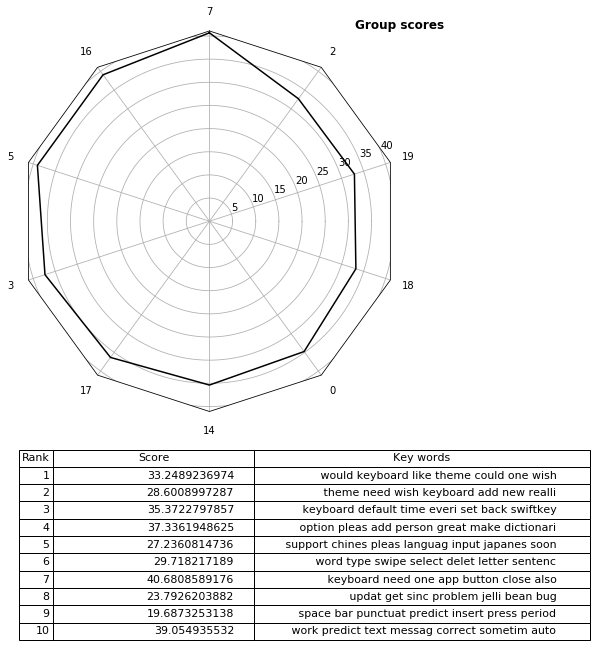

In [74]:
%run ./AR_visualization.py

group_count = 10
plot_group_ranking(group_scores, sorted_group_indices, top_words_list, group_count)

## IV. Evaluation


## V. Conclusion and Future Work



## VI. References
[1] N. Chen, J. Lin, S. C.H. Hoi, X. Xiao, B. Zhang. "AR-miner: mining informative reviews for developers from mobile app marketplace." ICSE, 2014.

[2] K. Nigam, A. K. McCallum, S. Thrun, and T. Mitchell. "Text classification from labeled and unlabeled documents using EM." Mach. Learn., 39(2-3):103–134, 2000.

[3] D. M. Blei, A. Y. Ng, and M. I. Jordan. "Latent dirichlet allocation." J. Mach. Learn. Res., 3:993–1022, 2003.

[4] B. Croft, D. Metzler, and T. Strohman. "Search Engines: Information Retrieval in Practice." Addison-Wesley Publishing Company, USA, 1st edition, 2009.

[5] M. Harman, Y. Jia, and Y. Zhang. "App store mining and analysis: Msr for app stores." In Proceedings of the 9th Working Conference on Mining Software Repositories, pages 108–111, 2012.

[6] R. Minelli and M. Lanza. "Software analytics for mobile applications–insights & lessons learned." CSMR, 2013.

[7] B. Fu, J. Lin, L. Li, C. Faloutsos, J. Hong, and N. Sadeh. "Why people hate your app: Making sense of user feedback in a mobile app store." KDD, pages 1276–1284, 2013.

[8] B. Pang and L. Lee. "Opinion mining and sentiment analysis." Found. Trends Inf. Retr., 2:1–135, 2008.

[9] C.-F. Hsu, E. Khabiri, and J. Caverlee. "Ranking comments on the social web." International Conference on Computational Science and Engineering, pages 90–97, 2009.

[10] L. V. Galvis Carreno and K. Winbladh. "Analysis of user comments: An approach for software requirements evolution." ICSE, pages 582–591, 2013.

[11] R. Mihalcea, and P. Tarau. "TextRank: Bringing order into texts." Association for Computational Linguistics, 2004.